### Pregunta 5
**¿Un Hashtag es más útil a la hora de entrenar un modelo para predecir un emoji?**

Para poder responder a la pregunta de si es más efectivo predecir un emoji a partir de hashtags o el contenido del tweet, se debe generar un nuevo data frame, el cual contenga solo los tweets que tienen hashtags, ya que el mantener los tweets sin hashtags no aporta información relevante para esta pregunta. 

Ahora bien, debido a que los hashtags se escriben sin espacios entre caracteres, no se puede hacer exactamente el mismo pre-procesamiento que se realizó para los caracteres del tweet. Es por esto, que se debe eliminar todo el contenido de cada hashtag que no aporta información sobre el contenido del tweet, en este caso, solo números y puntuación(.,!,#), donde además se debe procurar dejar todo el contenido del hashtag en minúscula.

Cabe recalcar, que de ser necesario, se realizará un reajuste en el balance de clases mediante subsampling, puesto que en la base de datos hay una mayor presencia de ciertos emojis, lo que puede generar resultados poco concluyentes.

Luego del pre-procesamiento, se deberán crear 2 dataset más, uno que contenga los tweets sin los hashtags y otro con solo los hashtags, ya que con esto podremos aplicar diferentes técnicas de clasificación a cada uno de los 3 data frame y podremos cuantificar la efectividad de los hashtags para predecir un emoji. A partir de esto, se ocupará el método de KNN, puesto que este es usado frecuentemente para búsquedas semánticas (procesamiento de lenguaje natural), asociando k puntos de datos más cercanos del dataset train a el punto de consulta (puede ser con distancia euclidiana), es decir, cuando se entrena el clasificador,  se asociaron k palabras para cada emoji y luego mediremos la distancia de cada palabra del test set con las del train set. 

Posteriormente, para poder comparar los resultados entre clasificadores y escoger el más óptimo, se ocupará adicionalmente el clasificador que tenga los mejores resultados en la pregunta 1, ya que el procedimiento es análogo en ambas preguntas. 

En consecuencia, para poder medir la efectividad de cada clasificador y poder hacer una comparación entre ellos, se utilizaran las métricas F1 score y sensibilidad, puesto que existe un desbalance entre clases (cantidad de cada emoji), haciendo que accuracy no sea la mejor métrica en este caso (de igual forma se espera un porcentaje sobre el 70%).

Finalmente, se escogieron estos dos clasificadores por sobre el resto, ya que trabajan de una manera más óptima en presencia de multiclases, acertando un mayor número de veces correctamente al emoji correspondiente, lo cual fue previamente observado en el procedimiento para la pregunta 1. 

In [1]:
import pandas as pd
import numpy as np
import pickle
from string import punctuation
 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.rc('axes', titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.titlesize'] = 16
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams.update({'lines.markeredgewidth': 1})
plt.rcParams.update({'errorbar.capsize': 2})
import plotly.express as px

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer # tokenizer especial para tweets
tt = TweetTokenizer()

In [3]:
file_names = {
    "df_es_mapping": "../../Data/mapping/df_es_mapping.pickle",
    "df_us_mapping": "../../Data/mapping/df_us_mapping.pickle",
    
    "df_es_test": "../../Data/test/df_es_test.pickle",
    "df_us_test": "../../Data/test/df_us_test.pickle",
    
    "df_es_train": "../../Data/train/df_es_train.pickle",
    "df_us_train": "../../Data/train/df_us_train.pickle",
    
    "df_es_trial": "../../Data/trial/df_es_trial.pickle",
    "df_us_trial": "../../Data/trial/df_us_trial.pickle",
}

In [10]:
df_es_train = pickle.load(open(file_names["df_es_train"], "rb"))
df_es_trial = pickle.load(open(file_names["df_es_trial"], "rb"))
df_es_test = pickle.load(open(file_names["df_es_test"], "rb"))

df_us_train = pickle.load(open(file_names["df_us_train"], "rb"))
df_us_trial = pickle.load(open(file_names["df_us_trial"], "rb"))
df_us_test = pickle.load(open(file_names["df_us_test"], "rb"))

In [11]:
df_es_train.head()

,id,text,label
0,793417168469757952,Es imposible quererte más @ Plaza Del Callao -...,0
1,718539939063926790,Disfrutando de buena comida con buena compañía...,4
2,670562346067193856,Muchísimas Felicidades M!!! Nos vemos pronto! ...,11
3,783680728538214400,Y pensar que a esta persona la conozco de hace...,11
4,711210617043075073,¡Que buenas son las noches así y que buena com...,17


In [12]:
# %%time
# df_es_train['tokenized_text'] = df_es_train['text'].str.lower().apply(lambda x: " ".join(tt.tokenize(x)))
# # df_es_train['tokenized_text'] = df_es_train['text'].str.lower().apply(tt.tokenize) 
# df_es_train.head()

In [13]:
%%time
df_es_train['tokenized_text'] = df_es_train['text'].str.lower().apply(tt.tokenize) 
df_es_train.head()

CPU times: total: 3.2 s
Wall time: 3.63 s


,id,text,label,tokenized_text
0,793417168469757952,Es imposible quererte más @ Plaza Del Callao -...,0,"[es, imposible, quererte, más, @, plaza, del, ..."
1,718539939063926790,Disfrutando de buena comida con buena compañía...,4,"[disfrutando, de, buena, comida, con, buena, c..."
2,670562346067193856,Muchísimas Felicidades M!!! Nos vemos pronto! ...,11,"[muchísimas, felicidades, m, !, !, !, nos, vem..."
3,783680728538214400,Y pensar que a esta persona la conozco de hace...,11,"[y, pensar, que, a, esta, persona, la, conozco..."
4,711210617043075073,¡Que buenas son las noches así y que buena com...,17,"[¡, que, buenas, son, las, noches, así, y, que..."


In [14]:
nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords_es = stopwords.words('spanish')
print(stopwords_es[:10])

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se']


[nltk_data] Downloading package stopwords to C:\Users\Gianluca
[nltk_data]     Musso\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
from string import punctuation
stopwords_es_withpunct = set(stopwords_es).union(set(punctuation))
print(list(stopwords_es_withpunct)[:10])

['{', 'se', 'han', 'estábamos', 'fue', 'teniendo', 'sería', 'tenidos', ';', 'esa']


In [16]:
df_es_train['tokenized_text'] = df_es_train['tokenized_text'].apply(lambda x: [word for word in x if word not in (stopwords_es_withpunct)])
df_es_train["length tokenized"] = df_es_train['tokenized_text'].apply(len)
df_es_train.head()

,id,text,label,tokenized_text,length tokenized
0,793417168469757952,Es imposible quererte más @ Plaza Del Callao -...,0,"[imposible, quererte, plaza, callao, madrid]",5
1,718539939063926790,Disfrutando de buena comida con buena compañía...,4,"[disfrutando, buena, comida, buena, compañía, ...",9
2,670562346067193856,Muchísimas Felicidades M!!! Nos vemos pronto! ...,11,"[muchísimas, felicidades, m, vemos, pronto, tk...",9
3,783680728538214400,Y pensar que a esta persona la conozco de hace...,11,"[pensar, persona, conozco, hace, quiero, maner...",9
4,711210617043075073,¡Que buenas son las noches así y que buena com...,17,"[¡, buenas, noches, así, buena, compañía, va, ...",8


In [17]:
from nltk.stem import PorterStemmer

# puede ser porter o wnl
porter = PorterStemmer()
wnl = WordNetLemmatizer()

In [18]:
%%time
df_es_train['StemmedTokenized_text'] = df_es_train['tokenized_text'].apply(lambda x: [porter.stem(word) for word in x])

CPU times: total: 4.59 s
Wall time: 5.82 s


In [19]:
df_es_train.head()

,id,text,label,tokenized_text,length tokenized,StemmedTokenized_text
0,793417168469757952,Es imposible quererte más @ Plaza Del Callao -...,0,"[imposible, quererte, plaza, callao, madrid]",5,"[impos, querert, plaza, callao, madrid]"
1,718539939063926790,Disfrutando de buena comida con buena compañía...,4,"[disfrutando, buena, comida, buena, compañía, ...",9,"[disfrutando, buena, comida, buena, compañía, ..."
2,670562346067193856,Muchísimas Felicidades M!!! Nos vemos pronto! ...,11,"[muchísimas, felicidades, m, vemos, pronto, tk...",9,"[muchísima, felicidad, m, vemo, pronto, tkkkkk..."
3,783680728538214400,Y pensar que a esta persona la conozco de hace...,11,"[pensar, persona, conozco, hace, quiero, maner...",9,"[pensar, persona, conozco, hace, quiero, maner..."
4,711210617043075073,¡Que buenas son las noches así y que buena com...,17,"[¡, buenas, noches, así, buena, compañía, va, ...",8,"[¡, buena, noch, así, buena, compañía, va, @user]"


Generar df de tweets que solo tengan hastags

Sacar puntuación y números de cada hashtag, además de dejar en minúscula.

Hacer df sin hastags

hacer df solo con los hastags

In [20]:
import re 
df_es_only_hashtags = pd.DataFrame()
df_es_only_hashtags['text']=df_es_train['text'].apply(lambda x: re.findall(r"#(\w+)", x))
df_es_only_hashtags[df_es_only_hashtags['text'].apply(lambda d: len(d)) > 0]

,text
11,[mama]
14,"[boy, girls, friends, day, work]"
27,[twinseurs]
31,[sananton2016]
32,[Mallorca]
...,...
81300,[aprovechandoelverano]
81307,[family]
81308,"[codigodescuento, SUITATP]"
81316,"[Baco, madrid2016]"


In [23]:
# este es el dataset de train completo filtrado con solo los tweets que tienen hashtag
df_es_train_filtered = df_es_train[df_es_only_hashtags['text'].apply(lambda d: len(d)) > 0]
df_es_train_filtered

,id,text,label,tokenized_text,length tokenized,StemmedTokenized_text
11,732910832930062336,Como me gusta reunirme con mi madre aun que si...,5,"[gusta, reunirme, madre, aun, siempre, caen, b...",9,"[gusta, reunirm, madr, aun, siempr, caen, bron..."
14,795284818866995200,Descansando un poco en el trabajo #boy #girls ...,13,"[descansando, trabajo, #boy, #girls, #friends,...",9,"[descansando, trabajo, #boy, #girl, #friend, #..."
27,694634313728532480,@user ya tenemos nuestro medidor de altura par...,1,"[@user, medidor, altura, #twinseurs, algemesí]",5,"[@user, medidor, altura, #twinseur, algemesí]"
31,689892121680056321,Los 4 fantásticamente quemados #sananton2016 @...,2,"[4, fantásticamente, quemados, #sananton2016, ...",9,"[4, fantásticament, quemado, #sananton2016, pu..."
32,795575808647696385,Sweet home! #Mallorca (@ Aeropuerto de Palma d...,4,"[sweet, home, #mallorca, aeropuerto, palma, ma...",7,"[sweet, home, #mallorca, aeropuerto, palma, ma..."
...,...,...,...,...,...,...
81300,761357182101254144,Las tardes son de Aloha #aprovechandoelverano ...,13,"[tardes, aloha, #aprovechandoelverano, aloha, ...",5,"[tard, aloha, #aprovechandoelverano, aloha, es..."
81307,748128577313464321,"Simplemente, gracias . #family @ Barrio Llored...",0,"[simplemente, gracias, #family, barrio, llored...",6,"[simplement, gracia, #famili, barrio, lloreda,..."
81308,664469119396368384,Cuantos conocéis así?? Jaja pontemasfuerte #co...,2,"[cuantos, conocéis, así, jaja, pontemasfuerte,...",8,"[cuanto, conocéi, así, jaja, pontemasfuert, #c..."
81316,705906790777688064,Templo de #Baco. Parque El Capricho. #madrid20...,9,"[templo, #baco, parque, capricho, #madrid2016,...",8,"[templo, #baco, parqu, capricho, #madrid2016, ..."


In [25]:
# se agrega al train las columnas tokenizadas con y sin hashtags
df_es_train_filtered['StemmedTokenized_text_wo_hashtag'] = df_es_train_filtered['StemmedTokenized_text'].apply(lambda li: [word for word in li if not word.startswith('#')])
df_es_train_filtered

C:\Users\Gianluca Musso\AppData\Local\Temp\ipykernel_5148\1235189460.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_es_train_filtered['StemmedTokenized_text_wo_hashtag'] = df_es_train_filtered['StemmedTokenized_text'].apply(lambda li: [word for word in li if not word.startswith('#')])


,id,text,label,tokenized_text,length tokenized,StemmedTokenized_text,StemmedTokenized_text_wo_hashtag
11,732910832930062336,Como me gusta reunirme con mi madre aun que si...,5,"[gusta, reunirme, madre, aun, siempre, caen, b...",9,"[gusta, reunirm, madr, aun, siempr, caen, bron...","[gusta, reunirm, madr, aun, siempr, caen, bron..."
14,795284818866995200,Descansando un poco en el trabajo #boy #girls ...,13,"[descansando, trabajo, #boy, #girls, #friends,...",9,"[descansando, trabajo, #boy, #girl, #friend, #...","[descansando, trabajo, madrid, spain]"
27,694634313728532480,@user ya tenemos nuestro medidor de altura par...,1,"[@user, medidor, altura, #twinseurs, algemesí]",5,"[@user, medidor, altura, #twinseur, algemesí]","[@user, medidor, altura, algemesí]"
31,689892121680056321,Los 4 fantásticamente quemados #sananton2016 @...,2,"[4, fantásticamente, quemados, #sananton2016, ...",9,"[4, fantásticament, quemado, #sananton2016, pu...","[4, fantásticament, quemado, puerto, lápice, c..."
32,795575808647696385,Sweet home! #Mallorca (@ Aeropuerto de Palma d...,4,"[sweet, home, #mallorca, aeropuerto, palma, ma...",7,"[sweet, home, #mallorca, aeropuerto, palma, ma...","[sweet, home, aeropuerto, palma, mallorca, @user]"
...,...,...,...,...,...,...,...
81300,761357182101254144,Las tardes son de Aloha #aprovechandoelverano ...,13,"[tardes, aloha, #aprovechandoelverano, aloha, ...",5,"[tard, aloha, #aprovechandoelverano, aloha, es...","[tard, aloha, aloha, escollera]"
81307,748128577313464321,"Simplemente, gracias . #family @ Barrio Llored...",0,"[simplemente, gracias, #family, barrio, llored...",6,"[simplement, gracia, #famili, barrio, lloreda,...","[simplement, gracia, barrio, lloreda, badalona]"
81308,664469119396368384,Cuantos conocéis así?? Jaja pontemasfuerte #co...,2,"[cuantos, conocéis, así, jaja, pontemasfuerte,...",8,"[cuanto, conocéi, así, jaja, pontemasfuert, #c...","[cuanto, conocéi, así, jaja, pontemasfuert, s2..."
81316,705906790777688064,Templo de #Baco. Parque El Capricho. #madrid20...,9,"[templo, #baco, parque, capricho, #madrid2016,...",8,"[templo, #baco, parqu, capricho, #madrid2016, ...","[templo, parqu, capricho, parqu, capricho, mad..."


In [36]:
df_es_train_filtered['StemmedTokenized_text_as_str'] = df_es_train_filtered['StemmedTokenized_text'].astype(object).apply(lambda x: ' '.join([str(i) for i in x]))
df_es_train_filtered['StemmedTokenized_text_wo_hashtag_as_str'] = df_es_train_filtered['StemmedTokenized_text_wo_hashtag'].astype(object).apply(lambda x: ' '.join([str(i) for i in x]))
df_es_train_filtered

C:\Users\Gianluca Musso\AppData\Local\Temp\ipykernel_5148\1891238454.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_es_train_filtered['StemmedTokenized_text_as_str'] = df_es_train_filtered['StemmedTokenized_text'].astype(object).apply(lambda x: ' '.join([str(i) for i in x]))
C:\Users\Gianluca Musso\AppData\Local\Temp\ipykernel_5148\1891238454.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_es_train_filtered['StemmedTokenized_text_wo_hashtag_as_str'] = df_es_train_filtered['StemmedTokenized_te

,id,text,label,tokenized_text,length tokenized,StemmedTokenized_text,StemmedTokenized_text_wo_hashtag,StemmedTokenized_text_as_str,StemmedTokenized_text_wo_hashtag_as_str
11,732910832930062336,Como me gusta reunirme con mi madre aun que si...,5,"[gusta, reunirme, madre, aun, siempre, caen, b...",9,"[gusta, reunirm, madr, aun, siempr, caen, bron...","[gusta, reunirm, madr, aun, siempr, caen, bron...",gusta reunirm madr aun siempr caen bronca #mama …,gusta reunirm madr aun siempr caen bronca …
14,795284818866995200,Descansando un poco en el trabajo #boy #girls ...,13,"[descansando, trabajo, #boy, #girls, #friends,...",9,"[descansando, trabajo, #boy, #girl, #friend, #...","[descansando, trabajo, madrid, spain]",descansando trabajo #boy #girl #friend #day #w...,descansando trabajo madrid spain
27,694634313728532480,@user ya tenemos nuestro medidor de altura par...,1,"[@user, medidor, altura, #twinseurs, algemesí]",5,"[@user, medidor, altura, #twinseur, algemesí]","[@user, medidor, altura, algemesí]",@user medidor altura #twinseur algemesí,@user medidor altura algemesí
31,689892121680056321,Los 4 fantásticamente quemados #sananton2016 @...,2,"[4, fantásticamente, quemados, #sananton2016, ...",9,"[4, fantásticament, quemado, #sananton2016, pu...","[4, fantásticament, quemado, puerto, lápice, c...",4 fantásticament quemado #sananton2016 puerto ...,4 fantásticament quemado puerto lápice castill...
32,795575808647696385,Sweet home! #Mallorca (@ Aeropuerto de Palma d...,4,"[sweet, home, #mallorca, aeropuerto, palma, ma...",7,"[sweet, home, #mallorca, aeropuerto, palma, ma...","[sweet, home, aeropuerto, palma, mallorca, @user]",sweet home #mallorca aeropuerto palma mallorca...,sweet home aeropuerto palma mallorca @user
...,...,...,...,...,...,...,...,...,...
81300,761357182101254144,Las tardes son de Aloha #aprovechandoelverano ...,13,"[tardes, aloha, #aprovechandoelverano, aloha, ...",5,"[tard, aloha, #aprovechandoelverano, aloha, es...","[tard, aloha, aloha, escollera]",tard aloha #aprovechandoelverano aloha escollera,tard aloha aloha escollera
81307,748128577313464321,"Simplemente, gracias . #family @ Barrio Llored...",0,"[simplemente, gracias, #family, barrio, llored...",6,"[simplement, gracia, #famili, barrio, lloreda,...","[simplement, gracia, barrio, lloreda, badalona]",simplement gracia #famili barrio lloreda badalona,simplement gracia barrio lloreda badalona
81308,664469119396368384,Cuantos conocéis así?? Jaja pontemasfuerte #co...,2,"[cuantos, conocéis, así, jaja, pontemasfuerte,...",8,"[cuanto, conocéi, así, jaja, pontemasfuert, #c...","[cuanto, conocéi, así, jaja, pontemasfuert, s2...",cuanto conocéi así jaja pontemasfuert #codigod...,cuanto conocéi así jaja pontemasfuert s2fit
81316,705906790777688064,Templo de #Baco. Parque El Capricho. #madrid20...,9,"[templo, #baco, parque, capricho, #madrid2016,...",8,"[templo, #baco, parqu, capricho, #madrid2016, ...","[templo, parqu, capricho, parqu, capricho, mad...",templo #baco parqu capricho #madrid2016 parqu ...,templo parqu capricho parqu capricho madrid


## Metrics without Hashtag

In [43]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_es_train_filtered['StemmedTokenized_text_wo_hashtag_as_str'])
y = df_es_train_filtered['label']
X

<24025x20323 sparse matrix of type '<class 'numpy.int64'>'
	with 110853 stored elements in Compressed Sparse Row format>

In [45]:
# entrenar knn con hashtags
import pandas
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.feature_extraction.text import CountVectorizer

# comparar metricas como recall precision accuracy f1

#split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 3)

# Fit the classifier to the data
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [48]:
from sklearn.metrics import classification_report
y_pred = knn.predict(X_test)
print(classification_report(y_test,y_pred))



              precision    recall  f1-score   support

           0       0.20      0.43      0.27      1315
           1       0.18      0.39      0.25      1232
          10       0.05      0.03      0.04       270
          11       0.03      0.01      0.02       167
          12       0.00      0.00      0.00       137
          13       0.04      0.05      0.05       249
          14       0.00      0.00      0.00        81
          15       0.03      0.02      0.02       109
          16       0.11      0.05      0.07       131
          17       0.25      0.03      0.05        70
          18       0.10      0.05      0.07       239
           2       0.15      0.02      0.04       745
           3       0.10      0.01      0.02       226
           4       0.14      0.04      0.06       551
           5       0.04      0.01      0.02       284
           6       0.26      0.04      0.07       332
           7       0.12      0.01      0.02       316
           8       0.19    

In [49]:
#Checking performance on the training set
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
#Checking performance on the test set
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))



Accuracy of K-NN classifier on training set: 0.42
Accuracy of K-NN classifier on test set: 0.18


## Metrics with Hashtag

In [50]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_es_train_filtered['StemmedTokenized_text_as_str'])
y = df_es_train_filtered['label']
X

<24025x44091 sparse matrix of type '<class 'numpy.int64'>'
	with 172380 stored elements in Compressed Sparse Row format>

In [51]:
# entrenar knn con hashtags
import pandas
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.feature_extraction.text import CountVectorizer

# comparar metricas como recall precision accuracy f1

#split dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 3)

# Fit the classifier to the data
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [52]:
from sklearn.metrics import classification_report
y_pred = knn.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.22      0.37      0.28      1315
           1       0.18      0.57      0.27      1232
          10       0.11      0.04      0.06       270
          11       0.05      0.02      0.03       167
          12       0.00      0.00      0.00       137
          13       0.22      0.02      0.03       249
          14       0.00      0.00      0.00        81
          15       0.25      0.03      0.05       109
          16       0.38      0.02      0.04       131
          17       0.12      0.03      0.05        70
          18       0.03      0.02      0.02       239
           2       0.17      0.03      0.04       745
           3       0.08      0.01      0.02       226
           4       0.30      0.03      0.06       551
           5       0.09      0.01      0.02       284
           6       0.44      0.02      0.05       332
           7       0.58      0.02      0.04       316
           8       0.40    

In [53]:
#Checking performance on the training set
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
#Checking performance on the test set
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))



Accuracy of K-NN classifier on training set: 0.44
Accuracy of K-NN classifier on test set: 0.20


## Histograma

In [62]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas
#import seaborn
#seaborn.set(style='ticks')

df=pd.DataFrame()
df['Atribute'] = ['precision', 'recall', 'f1-score', 'accuracy train_set', 'accuracy test_set']
df['clasifier_w_hashtags'] = [0.12, 0.08, 0.07, 0.42, 0.18] 
df['clasifier_wo_hashtags'] = [0.22, 0.08, 0.08, 0.44, 0.20]
df


,Atribute,clasifier_w_hashtags,clasifier_wo_hashtags
0,precision,0.12,0.22
1,recall,0.08,0.08
2,f1-score,0.07,0.08
3,accuracy train_set,0.42,0.44
4,accuracy test_set,0.18,0.20


<AxesSubplot:xlabel='Atribute'>

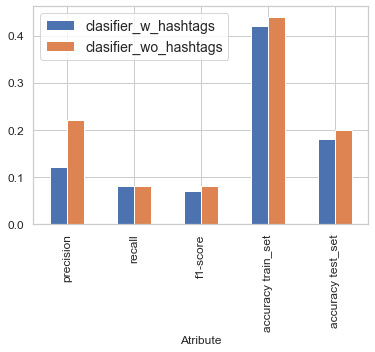

In [64]:
df.plot.bar(x='Atribute')